In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import SHIPS_ML_model_funcs
from utils import SHIPS_plotting
import matplotlib.colors
import os

##### Experiment info for both models

In [6]:
fpath_load = 'DATA/ML_model_results/TRAINING/'
train_yr_start = 2005
train_yr_end = 2018
mask_TYPE = 'SIMPLE'
is_stand = True
if is_stand:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'no_STANDARD'
RI_thresh = 30
wts_str = 'default'
score = 'f1_weighted'
N_samples = 15

##### RF experiment info

In [7]:
RF_crit = 'gini'
RF_path_suff = 'TRAIN_{RF_crit}_SHIPS_SIMPLE_RI_vs_no_RI_{train_yr_start}-{train_yr_end}_{mask_TYPE}_MASK_'\
'{stand_str}_RI_thresh_{RI_thresh}weights_{wts_str}_wts_{N_samples}_samples_{score}.csv'.format(RF_crit=RF_crit,
                           train_yr_start=train_yr_start,train_yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,N_samples=N_samples,score=score)

##### LR experiment info
We'll just use `lbfgs` since it's so similar to `sag` \ `saga`

In [65]:
LR_model = 'lbfgs'
LR_path_suff = 'TRAIN_{LR_model}_SHIPS_SIMPLE_RI_vs_no_RI_{train_yr_start}-{train_yr_end}_{mask_TYPE}_MASK_'\
'{stand_str}_RI_thresh_{RI_thresh}weights_{wts_str}_wts_{N_samples}_samples_{score}.csv'.format(LR_model=LR_model,
                           train_yr_start=train_yr_start,train_yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,N_samples=N_samples,score=score)

#### Part 1. Plots from confusion matrix
We can make several plots with our confusion matrix results:
* Performance diagram for training data
* Box plots of PoD, FAR, CSI; Hits, and Misses

In [66]:
cm_RF = pd.read_csv(fpath_load+'RF/Conf_Matrix'+RF_path_suff)
cm_RF['Model'] = 'Random Forest'
cm_LR = pd.read_csv(fpath_load+'LOGISTIC/Conf_Matrix'+LR_path_suff)
cm_LR['Model'] = 'Logistic Reg.'
cm_res = pd.concat([cm_RF,cm_LR])


##### Performance diagram.  
This plot summarizes our results for the training data. For our bootstrapped training data, we show the median false alarm ratio / probability of detection values as well as a 95% confidence interval (error bars). It also shows us our results in the context of frequency bias (diagonal lines; are we over/underforecasting our event?) and critical success index (contours), which is another metric that summarizes hits, misses, and false alarms all together.  

In [24]:
fig_dir_save = 'Figures/TRAINING/'
if not os.path.exists(fig_dir_save):
    os.makedirs(fig_dir_save)

In [34]:
def add_model_results(ax,CM,cat_sel='RI'):
    # Inputs:
    # ax: axes for corresponding figure
    # CM: dataframe containing confusion matrix 
    # Category selected: RI or not RI? Default is RI
    # 
    # Get the means, minima, and maxima for each model / basin
    CM_rs = CM.reset_index().set_index(['Category Names','BASIN','Model','Fold'])
    CM_mean = CM_rs.mean(level=(0,1,2))
    CM_min = CM.groupby(['Category Names','BASIN','Model']).quantile(0.025)
    CM_max = CM.groupby(['Category Names','BASIN','Model']).quantile(0.975)
    CM_ALL_sel = CM_mean.loc[cat_sel]
    # Get error bar bounds
    #y_lower = -1*CM_min.loc[cat_sel]['POD'].reset_index().sort_values('BASIN',ignore_index=True) + CM_ALL_sel['POD'].reset_index().sort_values('BASIN',ignore_index=True)
    #y_upper = CM_max.loc[cat_sel]['POD'].reset_index().sort_values('BASIN',ignore_index=True) + -1*CM_ALL_sel['POD'].reset_index().sort_values('BASIN',ignore_index=True)
    #cm_ALL_yerr = [y_lower.values,y_upper.values]
    #cm_ALL_yerr = [y_lower['POD'],y_upper['POD']]
    #
    #x_lower = -1*CM_min.loc[cat_sel]['SR'].reset_index().sort_values('BASIN',ignore_index=True) + CM_ALL_sel['SR'].reset_index().sort_values('BASIN',ignore_index=True)
   # x_upper = CM_max.loc[cat_sel]['SR'].reset_index().sort_values('BASIN',ignore_index=True) + -1*CM_ALL_sel['SR'].reset_index().sort_values('BASIN',ignore_index=True)

    #cm_ALL_xerr = [x_lower['SR'],x_upper['SR']]
    # Make a colormap for each basin
    colors_list = ['hot pink','navy','goldenrod','green','violet']
    pal_sel = sns.color_palette(sns.xkcd_palette(colors_list),5)
    # Plot error bars in both x and y
    #ax.errorbar(CM_ALL_sel.reset_index().sort_values('BASIN',ignore_index=True)['SR'],
    #            CM_ALL_sel.reset_index().sort_values('BASIN',ignore_index=True)['POD'],
     #           yerr=cm_ALL_yerr,xerr=cm_ALL_xerr,
     #      linestyle='none',linewidth=2,color='xkcd:slate grey',zorder=9)
    sns.scatterplot(data=CM_ALL_sel.reset_index().sort_values('BASIN',ignore_index=True),
                  x='SR',y='POD',hue='BASIN',style='Model',ax=ax,
                   palette=sns.set_palette(pal_sel),s=300,alpha=0.8,zorder=10)
    ax.legend(fontsize=16)

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


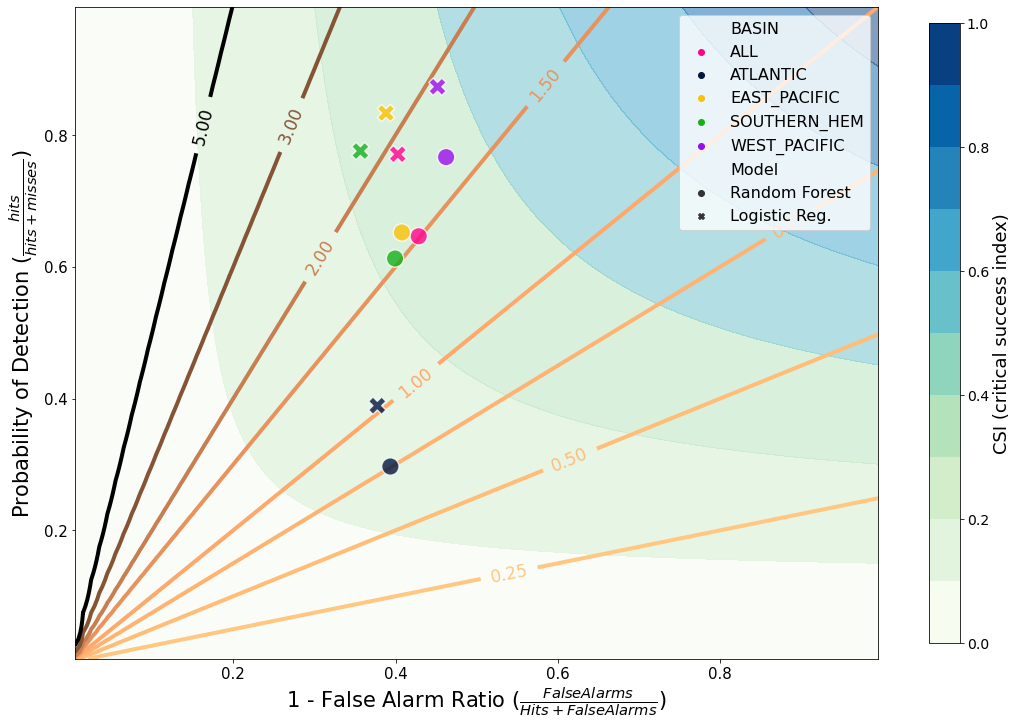

In [67]:
fig1,ax1 = plt.subplots(1,1,figsize=(18,12))
SHIPS_plotting.make_performance_diagram_background(ax1)
# Save empty PD in case we ever need it for a presentation
# fig1.savefig(fig_dir_save+'perf_diag_empty.png',format='png',dpi=350,bbox_inches='tight')
# fig1.savefig(fig_dir_save+'perf_diag_empty.pdf',format='pdf',bbox_inches='tight')
# Now, add results to PD
add_model_results(ax1,cm_res)

In [70]:
CM_rs = cm_res.reset_index().set_index(['Category Names','BASIN','Model','Fold'])
CM_mean = CM_rs.mean(level=(0,1,2))

In [71]:
CM_mean.xs('RI')['Threat']

BASIN         Model        
ATLANTIC      Random Forest    0.201817
EAST_PACIFIC  Random Forest    0.324163
WEST_PACIFIC  Random Forest    0.405932
SOUTHERN_HEM  Random Forest    0.318037
ALL           Random Forest    0.346152
ATLANTIC      Logistic Reg.    0.245575
EAST_PACIFIC  Logistic Reg.    0.360595
WEST_PACIFIC  Logistic Reg.    0.424154
SOUTHERN_HEM  Logistic Reg.    0.322853
ALL           Logistic Reg.    0.359689
Name: Threat, dtype: float64

<AxesSubplot:xlabel='BASIN'>

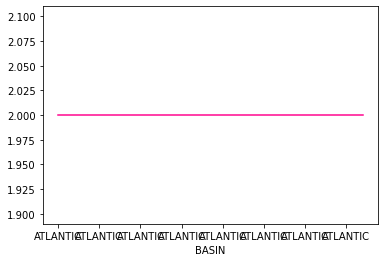

In [62]:
cm_RF.set_index(['Category Names','BASIN']).xs('RI')['Min Samples Leaf'].plot()